# Manga Colorization Using CycleGAN

Colorization is a widely time-consuming and expensive process for Japanese manga. Traditionally, Japanese manga are portrayed in black-and-white at debut; however, a large fraction of manga stall their colorized adaptations due to such bottlenecks. This project is intended to introduce a system to automate colorization and ideation for manga-related media using a Generative Adversarial Network (GAN).

## Getting Started

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as T
from torchvision.utils import save_image

import os, sys, copy
from tqdm import tqdm
import numpy as np

import matplotlib.pyplot as plt
from PIL import Image

from CycleGAN import ConvolutionalBlock
from CycleGAN import ResidualBlock
from CycleGAN import Generator
from CycleGAN import Discriminator

In [2]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"using device: {DEVICE}")

using device: cuda


In [3]:
BATCH_SIZE = 32
LEARNING_RATE = 1e-5
LAMBDA_CYCLE = 10
NUM_WORKERS = 4
NUM_EPOCHS = 50

TRAIN = False
LOAD_MODEL = False
SAVE_MODEL = False

TRAIN_DIR = "dataset/train_test"
VAL_DIR = "dataset/train_test"

GENERATOR_GRAY_DIR = "models/genh.pth.tar"
GENERATOR_COLOR_DIR = "models/genz.pth.tar"
DISCRIMINATOR_GRAY_DIR = "models/disch.pth.tar"
DISCRIMINATOR_COLOR_DIR = "models/discz.pth.tar"

## Manga Dataset

We will be using the [Japanese Manga Dataset](https://www.kaggle.com/datasets/chandlertimm/unified) sourced by CHANDLER TIMM DOLORIEL on `Kaggle`.

To download and setup this dataset, please create a `Kaggle` API token (you must also register for an account if you do not have one). You should get a `kaggle.json` file which contains your `Kaggle` API credentials. Move the `kaggle.json` file into the `/dataset` directory and run `python get_dataset.py`. This download will take a few minutes...

<div class="alert alert-info">
In addition to running the `get_dataset.py` script. Run the `train_test_split_dataset.ipynb` notebook to pre-process and split the manga image data into training and testing sets.
</div>

In [4]:
#!python get_dataset.py
# train_test_split_dataset.ipynb

CycleGANs uses unsupervised learning to generate images from one domain (gray) to another (color). Therefore, in our manga image dataset, we do not need paired or ground truth color images to train our CycleGANs. In the `train_test_split_dataset.ipynb`, we randomly combined and shuffled all manga panels regardless of the series.

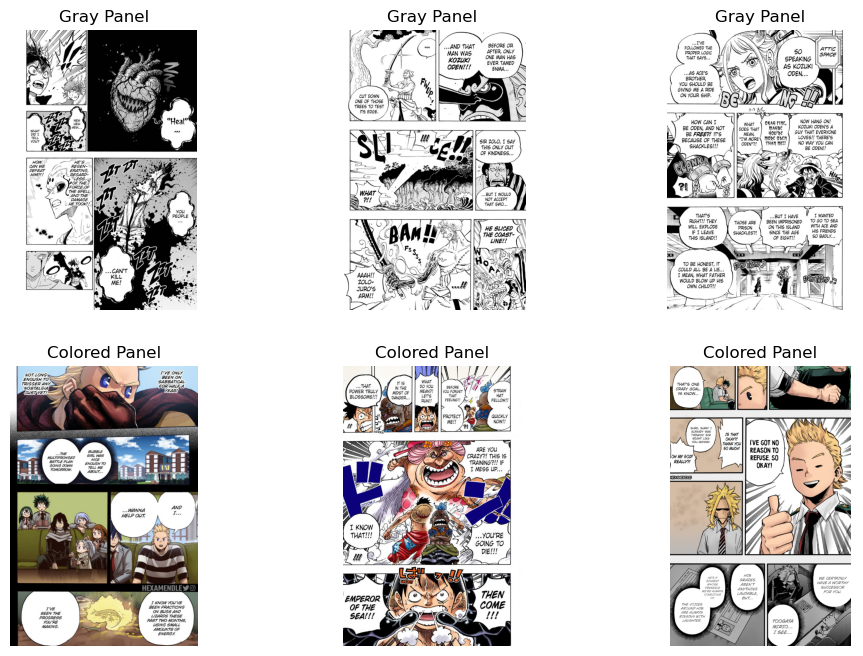

In [5]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))

for i in range(3):
    gray = plt.imread(f"{VAL_DIR}/test_gray/{i}.png", format="PNG")
    color = plt.imread(f"{VAL_DIR}/test_color/{i}.png", format="PNG")

    axes[0][i].imshow(gray)
    axes[0][i].axis('off')
    axes[0][i].set_title("Gray Panel")

    axes[1][i].imshow(color)
    axes[1][i].axis('off')
    axes[1][i].set_title("Colored Panel")

## Grayscale/Color Manga Dataloader

In [6]:
# Apply transforms and resize to 256x256
transforms = T.Compose(
    [
        T.Resize((256,256)),
        T.RandomHorizontalFlip(p=0.5),
        T.ToTensor(),
        T.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ]
)

In [7]:
from CycleGAN import MangaDataset

loader = DataLoader(MangaDataset(VAL_DIR, transforms_=transforms), batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

## Training Setup

In [8]:
def save_checkpoint(model, optimizer, filename="models/checkpoint.pth.tar"):
    print("=> Saving checkpoint")
    checkpoint = {
        "state_dict": model.state_dict(),
        "optimizer": optimizer.state_dict(),
    }
    torch.save(checkpoint, filename)

def load_checkpoint(checkpoint_file, model, optimizer, lr):
    print("=> Loading checkpoint")
    checkpoint = torch.load(checkpoint_file, map_location=DEVICE)
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])

    for param_group in optimizer.param_groups:
        param_group["lr"] = lr

In [9]:
def train_fn(disc_gray, disc_color, gen_color, gen_gray, loader, opt_disc, opt_gen, l1, mse, d_scaler, g_scaler):
    gray_reals = 0
    gray_fakes = 0
    loop = tqdm(loader, leave=True)

    for idx, (color, gray) in enumerate(loop):
        color = color.to(DEVICE)
        gray = gray.to(DEVICE)

        # Train discriminators gray and color
        with torch.cuda.amp.autocast():
            # Train disc gray
            fake_gray = gen_gray(color)
            D_gray_real = disc_gray(gray)
            D_gray_fake = disc_gray(fake_gray.detach())
            
            gray_reals += D_gray_real.mean().item()
            gray_fakes += D_gray_fake.mean().item()
            
            D_gray_real_loss = mse(D_gray_real, torch.ones_like(D_gray_real))
            D_gray_fake_loss = mse(D_gray_fake, torch.zeros_like(D_gray_fake))
            D_gray_loss = D_gray_real_loss + D_gray_fake_loss

            # Train disc color
            fake_color = gen_color(gray)
            D_color_real = disc_color(color)
            D_color_fake = disc_color(fake_color.detach())
            
            D_color_real_loss = mse(D_color_real, torch.ones_like(D_color_real))
            D_color_fake_loss = mse(D_color_fake, torch.zeros_like(D_color_fake))
            D_color_loss = D_color_real_loss + D_color_fake_loss

            D_loss = (D_gray_loss + D_color_loss) / 2

        opt_disc.zero_grad()
        d_scaler.scale(D_loss).backward()
        d_scaler.step(opt_disc)
        d_scaler.update()

        # Train generators gray and color
        with torch.cuda.amp.autocast():
            # adversarial losses
            D_gray_fake = disc_gray(fake_gray)
            D_color_fake = disc_color(fake_color)
            loss_G_gray = mse(D_gray_fake, torch.ones_like(D_gray_fake))
            loss_G_color = mse(D_color_fake, torch.ones_like(D_color_fake))

            # cycle losses
            cycle_color = gen_color(fake_gray)
            cycle_gray = gen_gray(fake_color)
            cycle_color_loss = l1(color, cycle_color)
            cycle_gray_loss = l1(gray, cycle_gray)

            # total loss
            G_loss = (
                loss_G_color
                + loss_G_gray
                + cycle_color_loss * LAMBDA_CYCLE
                + cycle_gray_loss * LAMBDA_CYCLE
            )

        opt_gen.zero_grad()
        g_scaler.scale(G_loss).backward()
        g_scaler.step(opt_gen)
        g_scaler.update()

        if idx % 200 == 0:
            save_image(fake_gray * 0.5 + 0.5, f"outputs/gray_{idx}.png")
            save_image(fake_color * 0.5 + 0.5, f"outputs/color_{idx}.png")

        loop.set_postfix(gray_reals = gray_reals / (idx + 1), gray_fakes = gray_fakes / (idx + 1))

In [10]:
disc_gray = Discriminator(in_channels=3).to(DEVICE)
disc_color = Discriminator(in_channels=3).to(DEVICE)
gen_color = Generator(img_channels=3, num_residuals=9).to(DEVICE)
gen_gray = Generator(img_channels=3, num_residuals=9).to(DEVICE)

# Use Adam Optimizer for both generator and discriminator
opt_disc = optim.Adam(
    list(disc_gray.parameters()) + list(disc_color.parameters()),
    lr=LEARNING_RATE,
    betas=(0.5, 0.999),
)

opt_gen = optim.Adam(
    list(gen_color.parameters()) + list(gen_gray.parameters()),
    lr=LEARNING_RATE,
    betas=(0.5, 0.999),
)

L1 = nn.L1Loss()
mse = nn.MSELoss()

## Training (~6 hours)

In [11]:
g_scaler = torch.cuda.amp.GradScaler()
d_scaler = torch.cuda.amp.GradScaler()

In [12]:
if LOAD_MODEL:
    load_checkpoint(
        GENERATOR_GRAY_DIR,
        gen_gray,
        opt_gen,
        LEARNING_RATE,
    )
    load_checkpoint(
        GENERATOR_COLOR_DIR,
        gen_color,
        opt_gen,
        LEARNING_RATE,
    )
    load_checkpoint(
        DISCRIMINATOR_GRAY_DIR,
        disc_gray,
        opt_disc,
        LEARNING_RATE,
    )
    load_checkpoint(
        DISCRIMINATOR_COLOR_DIR,
        disc_color,
        opt_disc,
        LEARNING_RATE,
    )

In [13]:
if TRAIN :
    for epoch in range(NUM_EPOCHS):
        train_fn(
            disc_gray, disc_color, gen_color, gen_gray,
            loader,
            opt_disc,
            opt_gen,
            L1,
            mse,
            d_scaler,
            g_scaler,
        )

        if SAVE_MODEL:
            save_checkpoint(gen_gray, opt_gen, filename=GENERATOR_GRAY_DIR)
            save_checkpoint(gen_color, opt_gen, filename=GENERATOR_COLOR_DIR)
            save_checkpoint(disc_gray, opt_disc, filename=DISCRIMINATOR_GRAY_DIR)
            save_checkpoint(disc_color, opt_disc, filename=DISCRIMINATOR_COLOR_DIR)

# Testing

In [14]:
val_loader = DataLoader(MangaDataset(VAL_DIR, transforms_=transforms), batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
data_iterator = iter(val_loader)
first_batch = next(data_iterator)

In [15]:
# Load the best model
load_checkpoint(
    "models/final/genz.pth.tar",
    gen_color,
    opt_gen,
    LEARNING_RATE,
)

=> Loading checkpoint


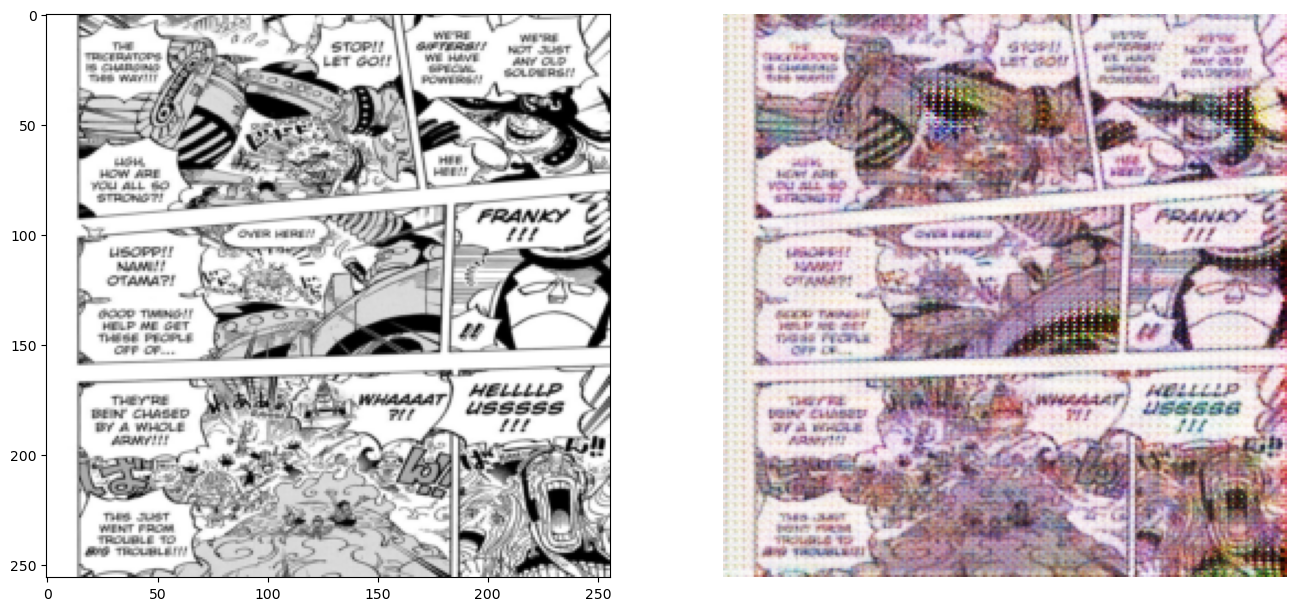

In [16]:
_, test_gray = first_batch
test_gray = test_gray.to(DEVICE)

fake_color = gen_color(test_gray)

# save_image(fake_horse * 0.5 + 0.5, f"outputs/horse_{idx}.png")
# save_image(fake_zebra * 0.5 + 0.5, f"outputs/zebra_{idx}.png")

test_gray = test_gray * 0.5 + 0.5
fake_color = fake_color * 0.5 + 0.5

test_gray_pil = T.ToPILImage()(test_gray[0])
fake_color_pil = T.ToPILImage()(fake_color[0])

# Load image as a tensor
loader = T.Compose([T.ToTensor()])
gray_tensor = loader(test_gray_pil).unsqueeze(0)
color_tensor = loader(fake_color_pil).unsqueeze(0)

# Display the image tensor
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 16))
axes[0].imshow(gray_tensor.squeeze().permute(1, 2, 0))
axes[1].imshow(color_tensor.squeeze().permute(1, 2, 0))

plt.axis('off')
plt.show()
